# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import sys
sys.path.append('../')

from unityagents import UnityEnvironment
from collections import deque

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils.config 
import pprint
import torch

env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86", no_graphics=True)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


### 2. Create instance of agent

Agent's hyperparameters are saved and loaded from config.py file in utils folder. Current values are result of selected after hyperparameter tuing. But you can try different hyperparameter values if you want.

If you just want to see the trained agent jump to cell 5.


In [2]:
#from agents.maddpg import MADDPG
from agents.maddpg_agent import MADDPG

# Load parameters from file
params = utils.config.HYPERPARAMS['Tennis1']

# Create agent instance
agent = MADDPG(params['agent'])
print("Created agent with following hyperparameter values:")
pprint.pprint(params['agent'])

Created agent with following hyperparameter values:
{'action_size': 2,
 'agent_name': 'MADDPG',
 'batch_size': 128,
 'buffer_size': 1000000,
 'fc1_units': 256,
 'fc2_units': 128,
 'gamma': 0.99,
 'lr_actor': 0.001,
 'lr_critic': 0.001,
 'n_agents': 2,
 'random_seed': 0,
 'state_size': 24,
 'tau': 0.06,
 'weight_decay': 0}


### 3. Train an agent!

In [3]:
# Reset and set environment to training mode
env_info = env.reset(train_mode=True)[brain_name]

# Maximum number of training episodes
n_episodes = params['n_episodes']

# List containing scores from each episode
scores = []

# Store last 100 scores
scores_window = deque(maxlen=params['scores_window_size'])

# Filename string
filename = "{:s}_lra{:.0E}_lrc{:.0E}_batch{:d}_fc:{:d}:{:d}_solved{:d}"

# Train loop
for i_episode in range(1, n_episodes+1):
    # Reset environment
    env_info = env.reset(train_mode=True)[brain_name]

    # Observe current state
    states = env_info.vector_observations

    # Reset score
    agent_scores = np.zeros(num_agents)

    # Loop each episode
    while True:

        # Select action 
        actions = agent.act(states, add_noise=True)

        # Take action
        env_info = env.step(actions)[brain_name]

        # Get next state, reward and done
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done

        # Store experience and learn
        agent.step(states, actions, rewards, next_states, dones)

        # State transition
        states = next_states

        # Update total score
        agent_scores += rewards
        
        # Exit loop if episode finished
        if np.any(dones):                                  
            break
            
    # Save most recent score
    scores_window.append(np.max(agent_scores))
    scores.append([np.max(agent_scores), np.mean(scores_window)])

    # Decay epsilon
    #epsilon = max(params['epsilon_final'], params['epsilon_decay']*epsilon)

    # Print learning progress
    print('\rEpisode {}\tAverage Score: {:.6f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % params['scores_window_size'] == 0:
        print('\rEpisode {}\tAverage Score: {:.6f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window)>=params['solve_score']:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        #filename = filename.format(hparams['name'], hparams['lr_actor'], hparams['lr_critic'], hparams['batch_size'],
        #                           hparams['fc1_units'], hparams['fc2_units'], i_episode-100)
        filename = 'checkpoint'
        agent.save(filename)
        break

Episode 100	Average Score: 0.006800
Episode 200	Average Score: 0.013700
Episode 300	Average Score: 0.027000
Episode 400	Average Score: 0.039800
Episode 500	Average Score: 0.073900
Episode 588	Average Score: 0.100400
Environment solved in 488 episodes!	Average Score: 0.10


### 4. Save and plot the score

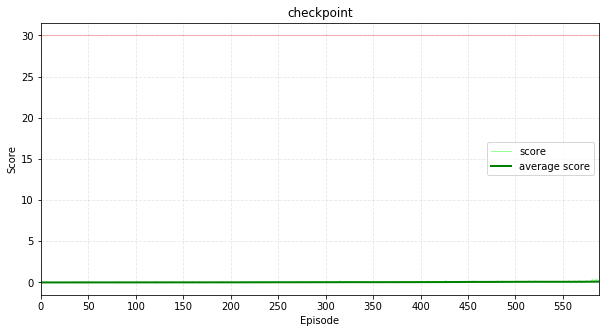

In [4]:
# Save score
df = pd.DataFrame(scores,columns=['scores','average_scores'])
df.to_csv('scores/{:s}.csv'.format(filename))

# Plot scores
plt.figure(figsize=(10,5))
plt.axhline(30, color='red', lw=1, alpha=0.3)
plt.plot( df.index, 'scores', data=df, color='lime', lw=1, label="score", alpha=0.4)
plt.plot( df.index, 'average_scores', data=df, color='green', lw=2, label="average score")
# Set labels and legends
plt.xlabel('Episode')
plt.xlim(0, len(df.index))
plt.xticks(50*np.arange(int(len(df.index)/50+1)))
plt.ylabel('Score')
#plt.yticks(3*np.arange(8))
plt.title(filename)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend()
# Save figure
plt.savefig('docs/plots/{:s}.png'.format(filename), bbox_inches='tight')
plt.show()

### 5. Watch smart agent

If you are skipped training, please specify filename for pre-trained network model.


In [5]:
# Speed (False: Real time, True: Fast)
train_mode = False

# reset the environment
env_info = env.reset(train_mode=train_mode)[brain_name]

# Load learned model weight. Load 'checkpoint_solved' for optimal model
#filename = 'checkpoint_solved'
agent.load(filename)

# Number of episodes to run
n_episodes = 1

# Run loop
for i_episode in range(1, n_episodes+1):
    # Reset environment
    env_info = env.reset(train_mode=train_mode)[brain_name]

    # Observe current state
    states = env_info.vector_observations

    # Reset score and done flag
    score = np.zeros(num_agents)

    # Episode loop
    while True:

        # Select action with greedy policy
        actions = agent.act(states, add_noise=False)

        # Take action
        env_info = env.step(actions)[brain_name]

        # Observe the next state
        next_states = env_info.vector_observations

        # Get the reward
        rewards = env_info.rewards

        # Check if episode is finished
        dones = env_info.local_done

        # State transition
        states = next_states

        # Update total score
        score += rewards
        
        # Exit loop if episode finished
        if np.any(dones):                                  
            break

    # Print episode summary
    print('Episode {} Score:{:.6f}'.format(i_episode, np.mean(score)))

Episode 1 Score:0.095000


When finished, close the environment.


In [6]:
env.close()